https://keras.io/examples/generative/conditional_gan/

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

2023-07-24 15:25:15.451071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:25:16.120212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

In [3]:
import h5py

In [4]:
batch_size = 64
num_channels = 3
num_classes = 4
image_size = 150
latent_dim = 128

In [5]:
data = h5py.File('processed_data.h5','r+')    

In [6]:
# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_pixels = np.array(data['X_train']).astype("float32") / 255.0
all_labels = np.array(data['y_train']).astype("float32")
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_pixels, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_pixels.shape}")
print(f"Shape of training labels: {all_labels.shape}")

/tmp/ipykernel_65394/1120434122.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  all_pixels = np.array(data['X_train']).astype("float32") / 255.0
/tmp/ipykernel_65394/1120434122.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  all_labels = np.array(data['y_train']).astype("float32")
2023-07-24 15:25:17.551743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Shape of training images: (2937, 150, 150, 3)
Shape of training labels: (2937, 4)


2023-07-24 15:25:17.567615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:25:17.567798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:25:17.568989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

132 7


In [8]:
discriminator_in_channels

7

In [9]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(10 * 10 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((10, 10, generator_in_channels)),
        layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (2, 2), strides=(5, 5), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [10]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [14]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='g_loss', patience=3)

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = cond_gan.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 7s 123ms/step - g_loss: 3.8283 - d_loss: 0.1641
Epoch 2/100
46/46 [==============================] - 6s 122ms/step - g_loss: 0.9222 - d_loss: 0.7818
Epoch 3/100
46/46 [==============================] - 6s 123ms/step - g_loss: 1.8995 - d_loss: 0.2246
Epoch 4/100
46/46 [==============================] - 6s 122ms/step - g_loss: 2.0644 - d_loss: 0.1852
Epoch 5/100
46/46 [==============================] - 6s 122ms/step - g_loss: 1.7673 - d_loss: 0.2434
Epoch 6/100
46/46 [==============================] - 6s 122ms/step - g_loss: 2.7753 - d_loss: 0.0971
Epoch 7/100
46/46 [==============================] - 6s 122ms/step - g_loss: 2.5590 - d_loss: 0.1406
Epoch 8/100
46/46 [==============================] - 6s 122ms/step - g_loss: 2.0580 - d_loss: 0.2415
Epoch 9/100
46/46 [==============================] - 6s 122ms/step - g_loss: 3.3021 - d_loss: 0.0558
Epoch 10/100
46/46 [==============================] - 6s 123ms/step - g_loss: 3.9349 - d_lo

KeyboardInterrupt: 

In [15]:
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
first_label = keras.utils.to_categorical([0], num_classes)
noise_and_labels = tf.concat([interpolation_noise, first_label], 1)
trained_gen = cond_gan.generator
fake = trained_gen.predict(noise_and_labels)

1/1 [==============================] - 0s 15ms/step


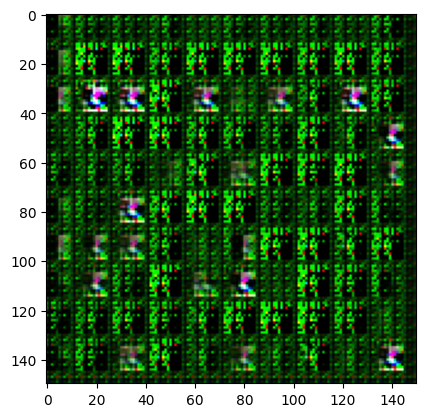

In [16]:
plt.imshow(fake[0])